# Lab 4. k-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in `sklearn.cluster.KMeans`.

We begin with the standard imports:

In [24]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The *cluster center* is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization (see the following figure):

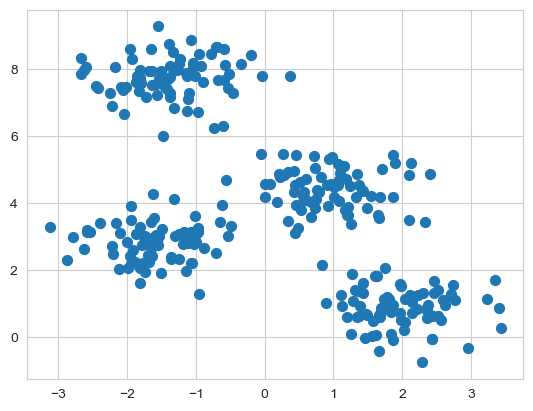

In [25]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels (the following figure).
We will also plot the cluster centers as determined by the *k*-means estimator:

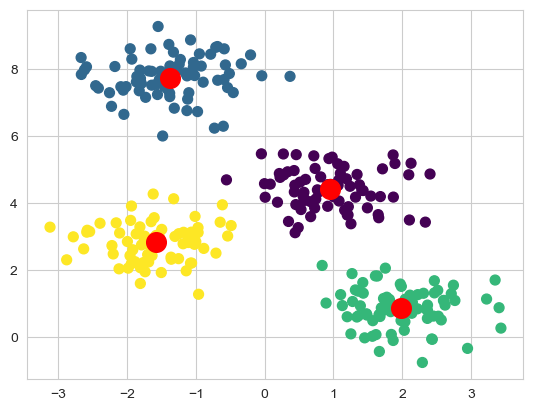

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200);
plt.show()

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly: after all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers.
2. Repeat until converged:
   1. *E-step*: Assign points to the nearest cluster center.
   2. *M-step*: Set the cluster centers to the mean of their assigned points.

Here the *E-step* or *expectation step* is so named because it involves updating our expectation of which cluster each point belongs to.
The *M-step* or *maximization step* is so named because it involves maximizing some fitness function that defines the locations of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)

The *k*-means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation (see the following figure):

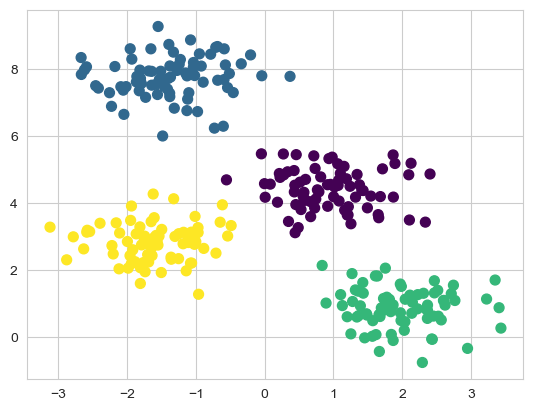

In [28]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.show()

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

There are a few caveats to be aware of when using the expectation–maximization algorithm:

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results (see the following figure):

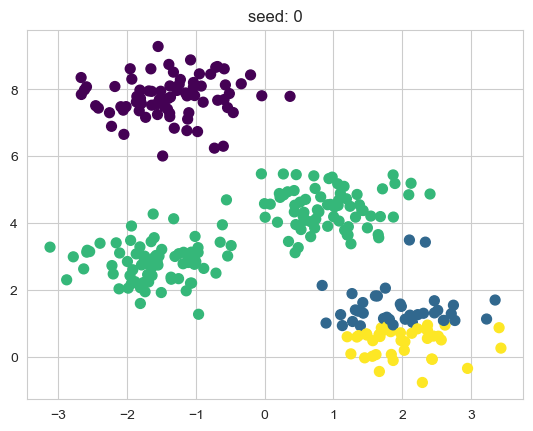

In [29]:
in_seed = 0
centers, labels = find_clusters(X, 4, rseed=in_seed)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.title(f'seed: {in_seed}');
plt.show()

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (the number is set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters, as shown in Figure 47-6:

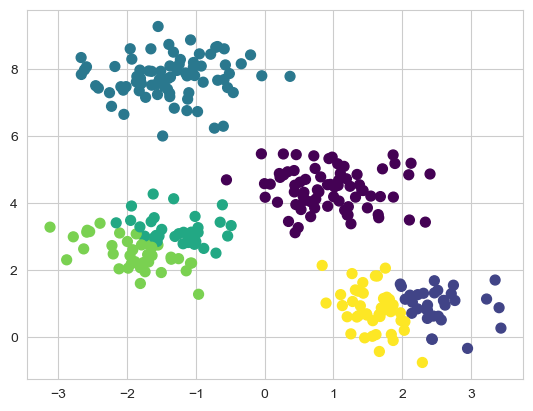

In [30]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.show()

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a variety of situations.
We'll now take a look at a couple of examples.

### Example 1: k-Means on Digits

To start, let's take a look at applying *k*-means on the simple digits data.
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the dataset, then find the clusters.
Recall that the digits dataset consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8 × 8 image:

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [32]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can be interpreted as representing the "typical" digit within the cluster.
Let's see what these cluster centers look like (see the following figure):

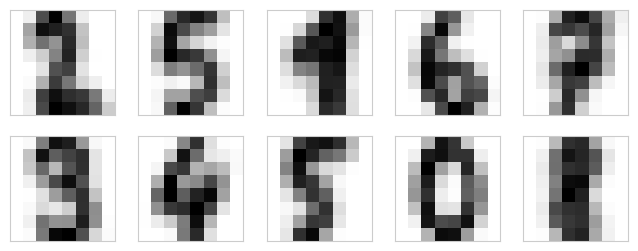

In [33]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.show()

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identities of the clusters, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in the clusters:

In [34]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this, visualized in the following figure:

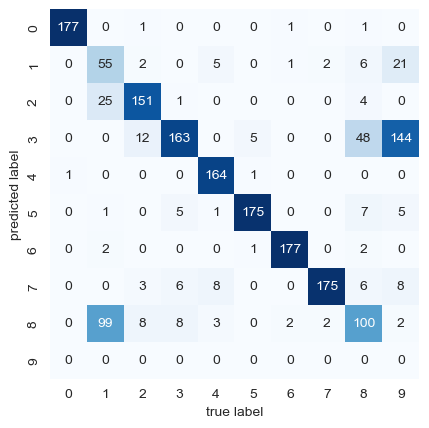

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = digits.target
y_pred = labels
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!


# Activity 4
Please, apply k-means to the following dataset, visualize it, and submit your result on [AhaSlides](https://ahaslides.com/58LUP).

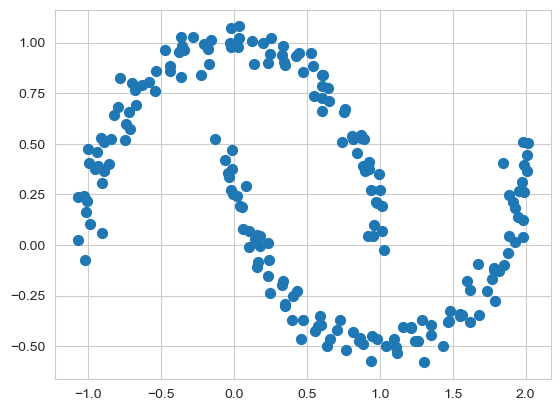

In [37]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);
plt.show()

## Acknowledgement
This notebook is based on material from [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/index.html) by Jake VanderPlas.